<h1>Digit Classification with Softmax</h1>


Importing required libraries

In [3]:
!pip install torch torchvision torchaudio

In [10]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms #for transforming data
import torchvision.datasets as dsets #for downloading the digit dataset
import matplotlib.pyplot as plt
import numpy as np

Function to plot the parameters of the Softmax function

In [7]:
# The function to plot parameters

def PlotParameters(model):
    W = model.state_dict()['linear.weight'].data
    w_min = W.min().item()
    w_max = W.max().item()
    fig, axes = plt.subplots(2, 5)
    fig.subplots_adjust(hspace=0.01, wspace=0.1)
    for i, ax in enumerate(axes.flat):
        if i < 10:

            # Set the label for the sub-plot.
            ax.set_xlabel("class: {0}".format(i))

            # Plot the image.
            ax.imshow(W[i, :].view(28, 28), vmin=w_min, vmax=w_max, cmap='seismic')

            ax.set_xticks([])
            ax.set_yticks([])

    plt.show()

Function to visualise the data

In [8]:
# Plot the data
def show_data(data_sample):
    plt.imshow(data_sample[0].numpy().reshape(28, 28), cmap='gray')
    plt.title('y = ' + str(data_sample[1]))

<h2 id="Makeup_Data">Generating Data</h2>


Loading the training dataset by setting the parameters <code>train</code> to <code>True</code> and converting it to a tensor by placing a transform object in the argument <code>transform</code>.


In [13]:
# Create and print the training dataset

train_dataset = dsets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
print("\nTraining dataset:\n ", train_dataset)


Training dataset:
  Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()


Loading the <em>testing</em> dataset and converting it to a tensor by placing a transform object in the argument <code>transform</code>.


In [14]:
# Create and print the validation dataset

validation_dataset = dsets.MNIST(root='./data', download=True, transform=transforms.ToTensor())
print("Print the validation dataset:\n ", validation_dataset)

Print the validation dataset:
  Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()


Plotting some smaples for visualization

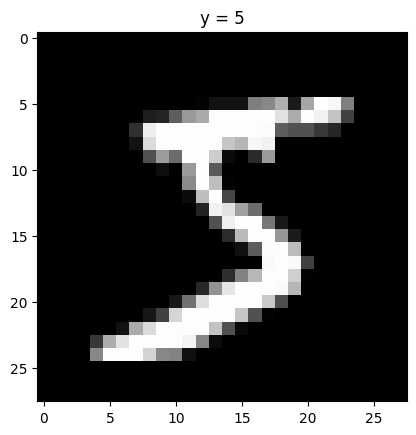

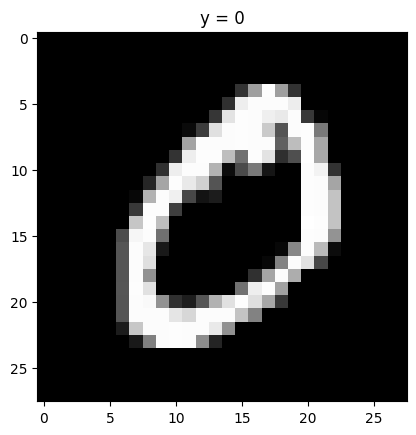

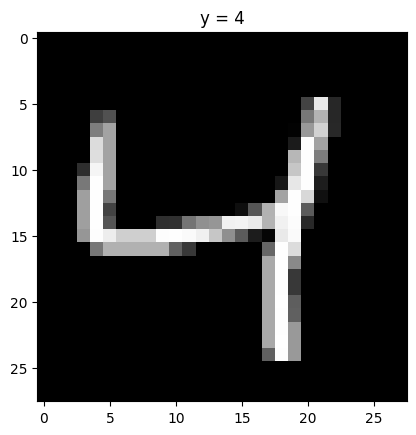

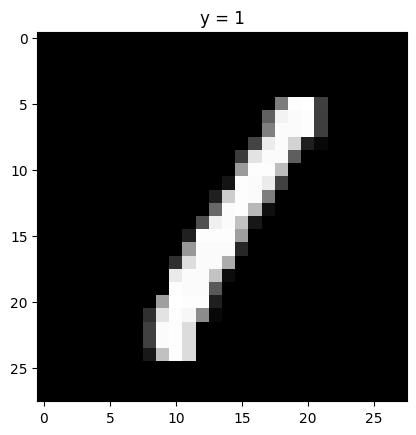

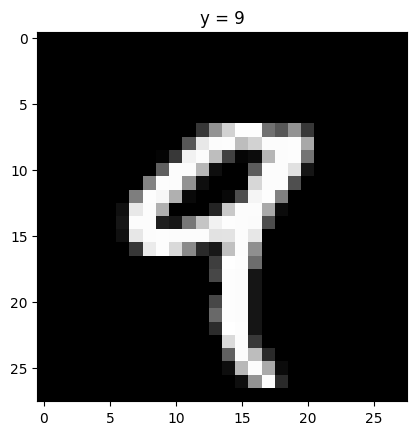

In [20]:
# Printing the first image and label

for i in range(5):
  show_data(train_dataset[i])
  plt.show()

<h2 id="#Classifier">Building a Softmax Classifer</h2>


Softmax classifier class

In [21]:
# Define softmax classifier class
# Inherits nn.Module which is the base class for all neural networks
class SoftMax(nn.Module):

    # Constructor
    def __init__(self, input_size, output_size):
        super(SoftMax, self).__init__()
        # Creates a layer of given input size and output size
        self.linear = nn.Linear(input_size, output_size)

    # Prediction
    def forward(self, x):
        # Runs the x value through the single layers defined above
        z = self.linear(x)
        return z

In [22]:
# Printign the shape of the training dataset

train_dataset[0][0].shape

torch.Size([1, 28, 28])

Flattening the tensors

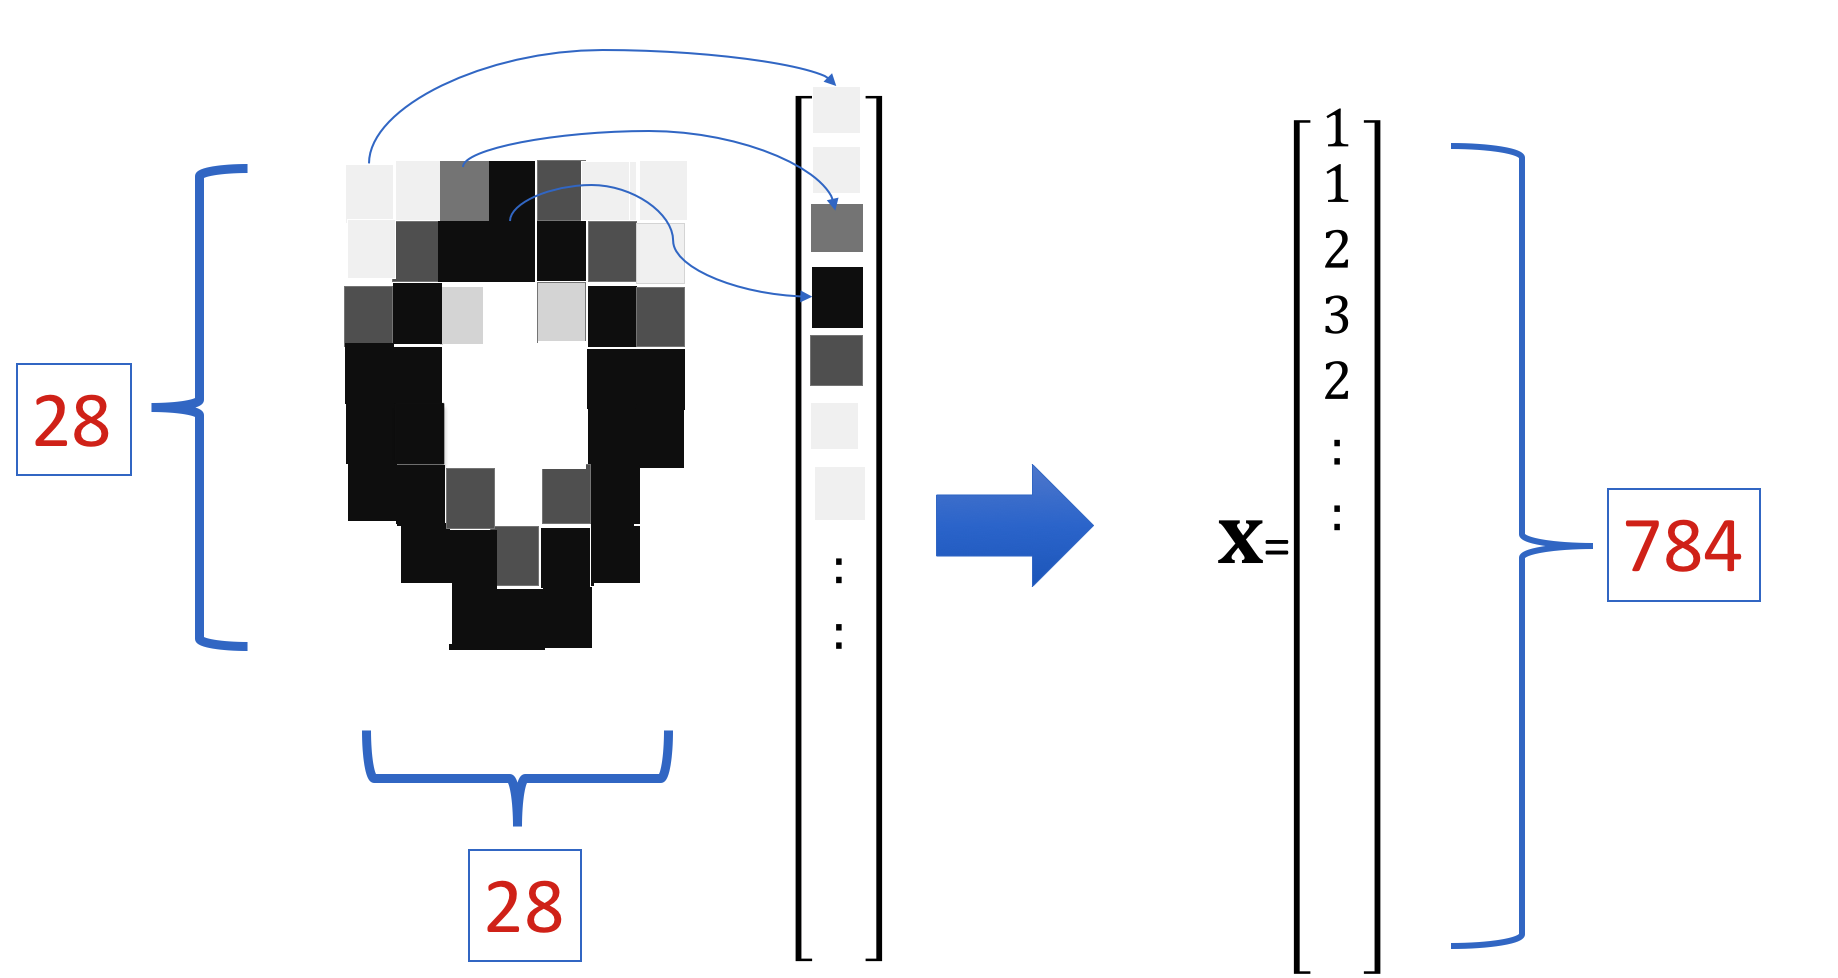

In [23]:
# Setting the input and output size

input_dim = 28 * 28
output_dim = 10

<h2 id="Model">Defining the Softmax Classifier, Criterion Function, Optimizer, and Training the Model</h2>


In [25]:
model = SoftMax(input_dim, output_dim)
print("\nModel:\n ", model)


Model:
  SoftMax(
  (linear): Linear(in_features=784, out_features=10, bias=True)
)


In [26]:
# Viewing the size of model parameters

print('w: ', list(model.parameters())[0].size())
print('b: ', list(model.parameters())[1].size())

w:  torch.Size([10, 784])
b:  torch.Size([10])


Plotting the model parameters for each class as a square image:


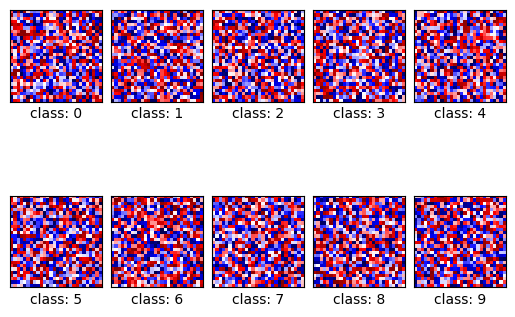

In [27]:
PlotParameters(model)

Predicting

In [29]:
# X value of the first image
X = train_dataset[0][0]
# Flatenning the shape from 1 by 28 by 28 to 1 by 28 * 28 (784)
print(X.shape)
X = X.view(-1, 28*28)
print(X.shape)
model(X)

torch.Size([1, 28, 28])
torch.Size([1, 784])


tensor([[-0.0991, -0.0812, -0.3512,  0.1196, -0.1116, -0.0473,  0.2056, -0.0408,
          0.1619, -0.1846]], grad_fn=<AddmmBackward0>)

Defining the learning rate, optimizer, criterion, data loader:


In [30]:
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
# The criterion will measure the loss between the prediction and actual label values
# This is where the SoftMax occurs, it is built into the Criterion Cross Entropy Loss
criterion = nn.CrossEntropyLoss()
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=5000)

Output:  tensor([[-0.0991, -0.0812, -0.3512,  0.1196, -0.1116, -0.0473,  0.2056, -0.0408,
          0.1619, -0.1846]], grad_fn=<AddmmBackward0>)
Actual: tensor([5])


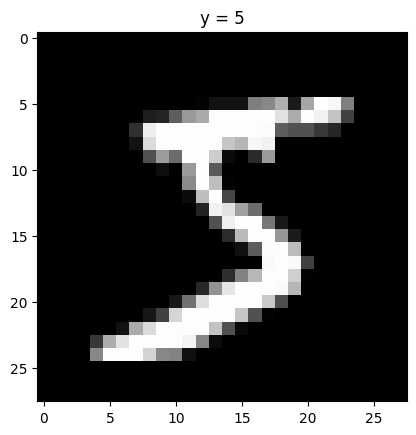

In [31]:
model_output = model(X)
actual = torch.tensor([train_dataset[0][1]])

show_data(train_dataset[0])
print("Output: ", model_output)
print("Actual:", actual)

In [32]:
criterion(model_output, actual)

tensor(2.3197, grad_fn=<NllLossBackward0>)

Cross Entropy Loss takes probabilities and we can see that `model_output` are not probabilities, this is where softmax comes in


In [33]:
softmax = nn.Softmax(dim=1)
probability = softmax(model_output)
print(probability)

tensor([[0.0933, 0.0950, 0.0725, 0.1162, 0.0922, 0.0983, 0.1266, 0.0989, 0.1212,
         0.0857]], grad_fn=<SoftmaxBackward0>)


Now that we have probabilities, we can just calculate the negative log of the probability of the class that this image belongs to. The image belongs to the target class so we calculate the negative log of the probability at the target index.


In [34]:
-1*torch.log(probability[0][actual])

tensor([2.3197], grad_fn=<MulBackward0>)

### Training the model

In [35]:
n_epochs = 10
# Lists to keep track of loss and accuracy
loss_list = []
accuracy_list = []
N_test = len(validation_dataset)

def train_model(n_epochs):
    for epoch in range(n_epochs):
        for x, y in train_loader:
            # Resets the calculated gradient value
            optimizer.zero_grad()
            # Makes a prediction based on the image tensor
            z = model(x.view(-1, 28 * 28))
            # Calculates loss between the model output and actual class
            loss = criterion(z, y)
            # Calculates the gradient value with respect to each weight and bias
            loss.backward()
            # Updates the weight and bias according to calculated gradient value
            optimizer.step()

        # Checking the performance of the model at each epoch with validation data
        correct = 0
        for x_test, y_test in validation_loader:
            # Makes prediction based on image tensor
            z = model(x_test.view(-1, 28 * 28))
            # Finds the class with the higest output
            _, yhat = torch.max(z.data, 1)
            # Checks if the prediction matches the actual class and increments correct if it does
            correct += (yhat == y_test).sum().item()

        accuracy = correct / N_test
        loss_list.append(loss.data)
        accuracy_list.append(accuracy)

train_model(n_epochs)

### Analysing results

Plotting the loss and accuracy on the validation data:


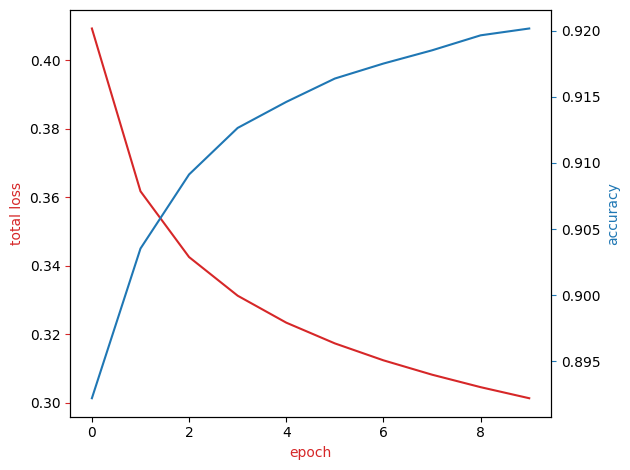

In [36]:
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(loss_list,color=color)
ax1.set_xlabel('epoch',color=color)
ax1.set_ylabel('total loss',color=color)
ax1.tick_params(axis='y', color=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color)
ax2.plot( accuracy_list, color=color)
ax2.tick_params(axis='y', color=color)
fig.tight_layout()

In [38]:
print("Maximum loss ", max(loss_list))
print("Maximum accuracy ", max(accuracy_list))

Maximum loss  tensor(0.4093)
Maximum accuracy  0.9201666666666667


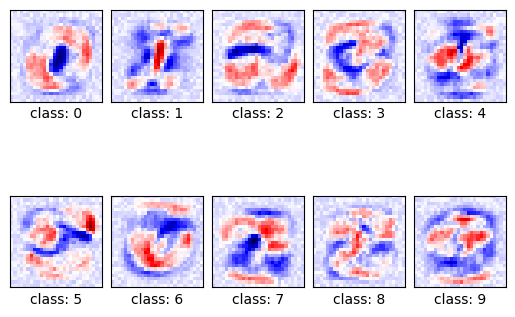

In [37]:
# Plotting the parameters

PlotParameters(model)

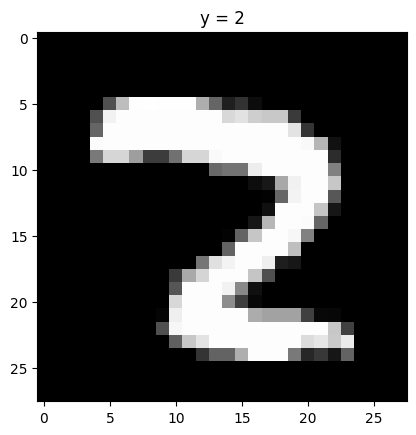

yhat: tensor([7])
probability of class  0.6915891170501709


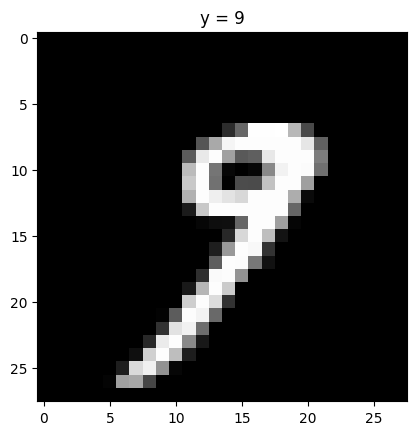

yhat: tensor([7])
probability of class  0.7069520354270935


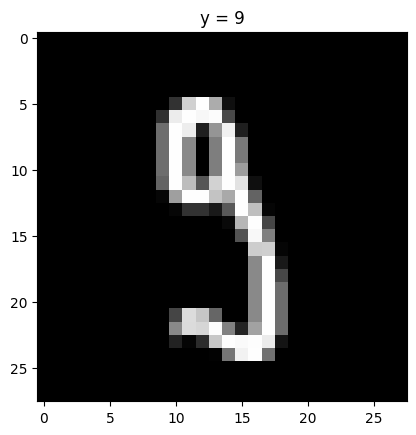

yhat: tensor([5])
probability of class  0.7244120836257935


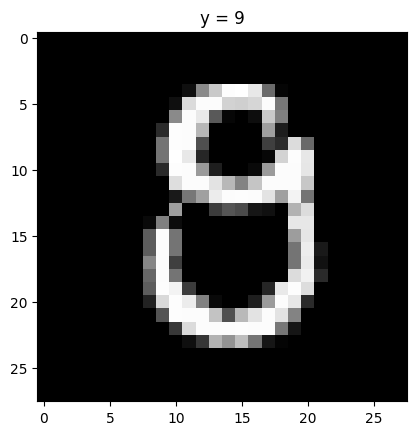

yhat: tensor([8])
probability of class  0.3830261826515198


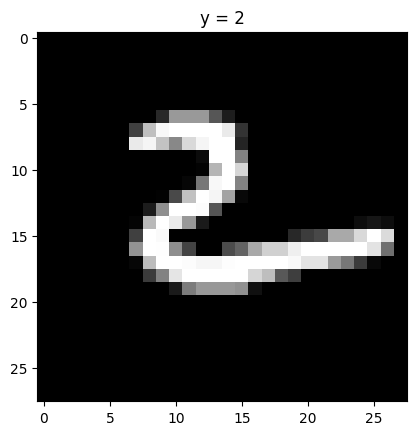

yhat: tensor([6])
probability of class  0.5121404528617859


In [39]:
# Plotting the first five misclassified samples
Softmax_fn=nn.Softmax(dim=-1)
count = 0
for x, y in validation_dataset:
    z = model(x.reshape(-1, 28 * 28))
    _, yhat = torch.max(z, 1)
    if yhat != y:
        show_data((x, y))
        plt.show()
        print("yhat:", yhat)
        print("probability of class ", torch.max(Softmax_fn(z)).item())
        count += 1
    if count >= 5:
        break

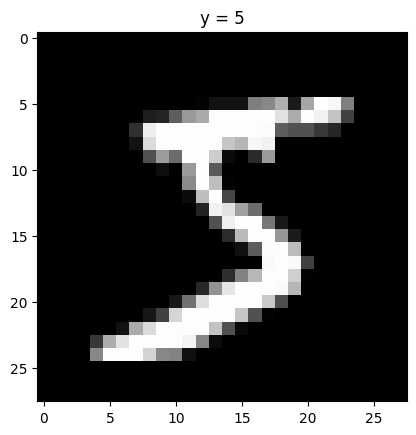

yhat: tensor([5])
probability of class  0.8466916084289551


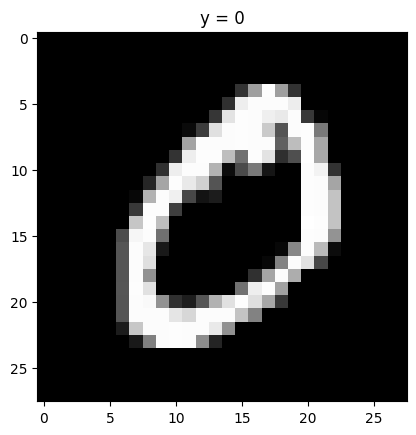

yhat: tensor([0])
probability of class  0.9996993541717529


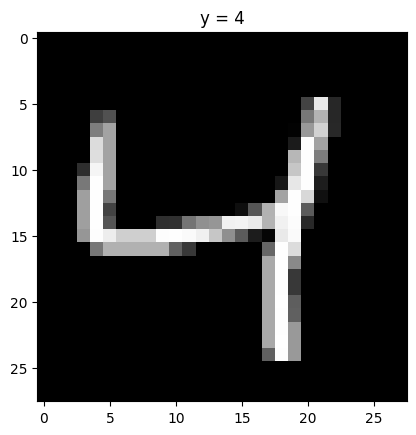

yhat: tensor([4])
probability of class  0.8716161251068115


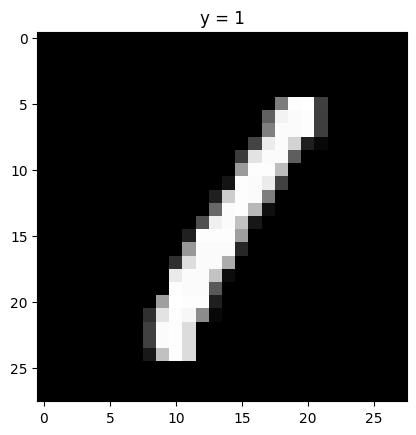

yhat: tensor([1])
probability of class  0.9648903608322144


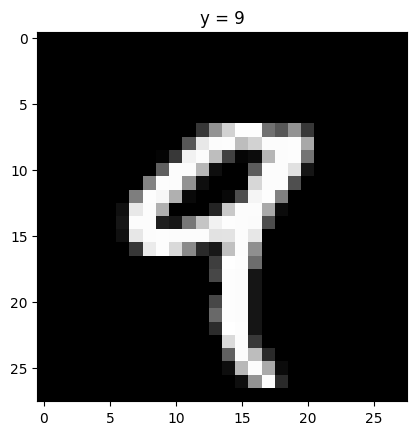

yhat: tensor([9])
probability of class  0.9266720414161682


In [40]:
# Plotting the firt five correctly classified samples
Softmax_fn=nn.Softmax(dim=-1)
count = 0
for x, y in validation_dataset:
    z = model(x.reshape(-1, 28 * 28))
    _, yhat = torch.max(z, 1)
    if yhat == y:
        show_data((x, y))
        plt.show()
        print("yhat:", yhat)
        print("probability of class ", torch.max(Softmax_fn(z)).item())
        count += 1
    if count >= 5:
        break